In [19]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models_vit
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def prepare_model(chkpt_dir, arch='vit_large_patch16'):
    # build model
    model = models_vit.__dict__[arch](
        img_size=224,
        num_classes=5,
        drop_path_rate=0,
        global_pool=True,
    )
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    return model

def run_one_image(img, model):
    
    x = torch.tensor(img)
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    
    x = x.to(device, non_blocking=True)
    latent = model.forward_features(x.float())
    latent = torch.squeeze(latent)
    
    return latent

### Load a pre-trained model

In [6]:
# download pre-trained RETFound 

chkpt_dir = './RETFound_cfp_weights.pth'
model_ = prepare_model(chkpt_dir, 'vit_large_patch16')

device = torch.device('cuda')
model_.to(device)
print('Model loaded.')

Model loaded.


### Converting DICOM images to PNG

In [7]:
import os
import pydicom
from PIL import Image

In [8]:
# function for converting DICOM to PNG
def dicom_to_png(dicom_path, png_path):
    ds = pydicom.dcmread(dicom_path)
    img = ds.pixel_array
    img = Image.fromarray(img)
    img.save(png_path)

# convert all DICOM images in a folder to PNG
def convert_dicom_folder_to_png(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in os.listdir(input_folder):
        if filename.endswith('.dcm'):
            dicom_path = os.path.join(input_folder, filename)
            png_path = os.path.join(output_folder, filename.replace('.dcm', '.png'))
            dicom_to_png(dicom_path, png_path)

input_folder = 'Białystok_PLUS_photos/przykładowe_zdjęcia'
output_folder = 'Białystok_PLUS_photos/przykładowe_zdjęcia/PNG'
convert_dicom_folder_to_png(input_folder, output_folder)

### Load images and save latent feature

In [9]:
# get image list
data_path = 'Białystok_PLUS_photos/przykładowe_zdjęcia/PNG'
img_list = os.listdir(data_path)

name_list = []
feature_list = []
model_.eval()

for i in img_list:
    img = Image.open(os.path.join(data_path, i))
    img = img.resize((224, 224))
    img = np.array(img)
    
    # checking the number of channels
    if img.ndim == 2:
        img = np.stack((img,) * 3, axis=-1)  # convert to RGB format

    img = img / 255.
    
    print(f"Shape of image {i}: {img.shape}")
    
    assert img.shape == (224, 224, 3)

    # normalize by mean and sd
    # can use customised mean and sd for your data
    img = img - imagenet_mean
    img = img / imagenet_std
    
    latent_feature = run_one_image(img, model_)
    
    name_list.append(i)
    feature_list.append(latent_feature.detach().cpu().numpy())
    

Shape of image 12774_20240415091903059.png: (224, 224, 3)
Shape of image 12774_20240415091904164.png: (224, 224, 3)
Shape of image 12774_20240415091904876.png: (224, 224, 3)
Shape of image 12774_20240415091905556.png: (224, 224, 3)
Shape of image 12774_20240415091906291.png: (224, 224, 3)
Shape of image 12774_20240415091907319.png: (224, 224, 3)
Shape of image 12774_20240415091907896.png: (224, 224, 3)
Shape of image 15504_20240415122327193.png: (224, 224, 3)
Shape of image 15504_20240415122327945.png: (224, 224, 3)
Shape of image 15504_20240415122328756.png: (224, 224, 3)
Shape of image 15504_20240415122329505.png: (224, 224, 3)
Shape of image 15504_20240415122330244.png: (224, 224, 3)
Shape of image 15504_20240415122330667.png: (224, 224, 3)
Shape of image 15774_20240415100248187.png: (224, 224, 3)
Shape of image 15774_20240415100248889.png: (224, 224, 3)
Shape of image 15774_20240415100249763.png: (224, 224, 3)
Shape of image 15774_20240415100250948.png: (224, 224, 3)
Shape of image

In [ ]:
latent_csv = pd.DataFrame({'Name':name_list, 'Latent_feature':feature_list})
latent_csv.to_csv('feature_latent.csv', index = False, encoding='utf8')

In [ ]:
latent_features = np.array(feature_list)

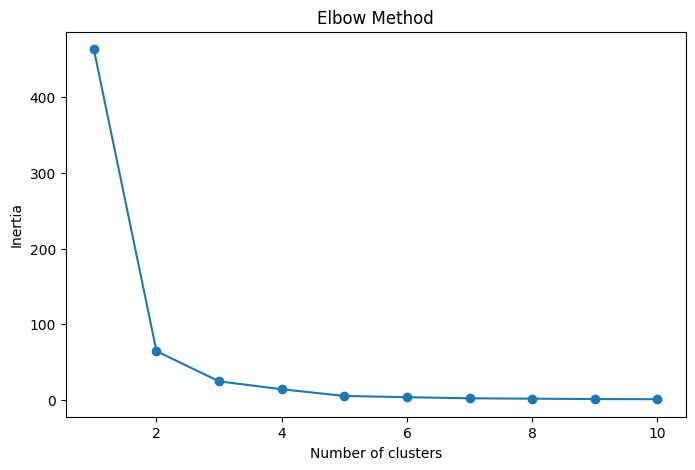

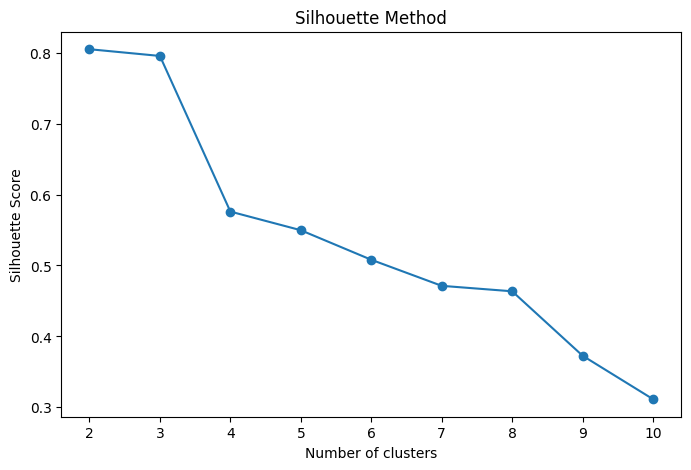

In [13]:
# application of PCA for reducing the dimensionality to 2D
pca = PCA(n_components=2)
latent_features_2d = pca.fit_transform(latent_features)

# elbow method
def plot_elbow_method(data, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

plot_elbow_method(latent_features_2d)

# silhouette analysis
def plot_silhouette_method(data, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

plot_silhouette_method(latent_features_2d)

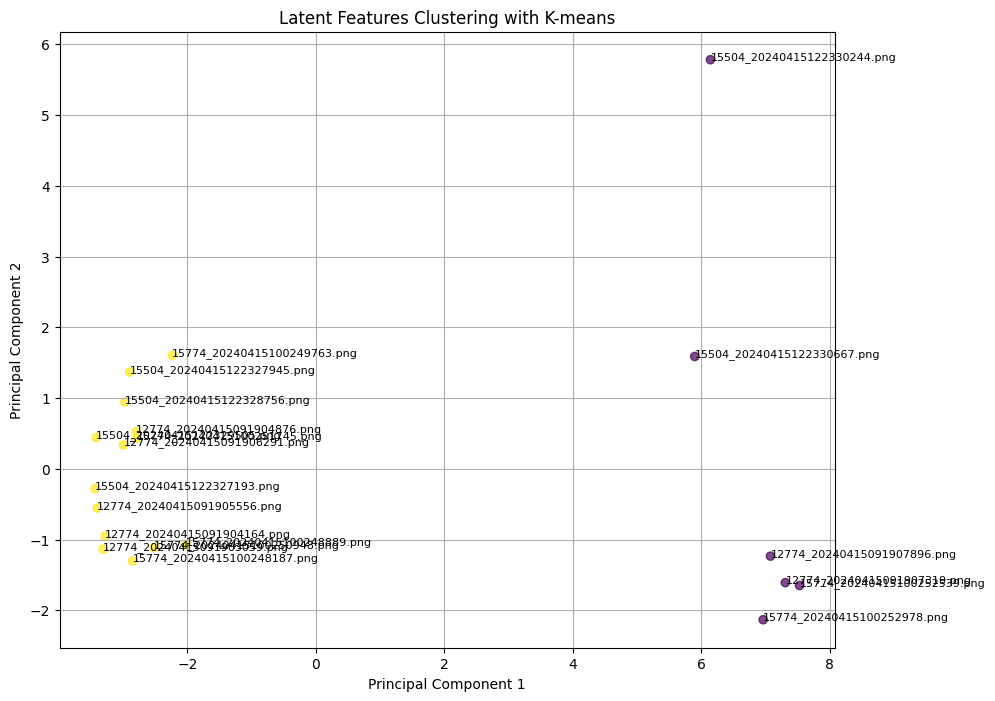

In [32]:
# determination of the optimal number of clusters (based on analysis)
optimal_clusters = 2

# using K-means with an optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0)
clusters = kmeans.fit_predict(latent_features_2d)

# visualisation of clusters with captions
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_features_2d[:, 0], latent_features_2d[:, 1], c=clusters, cmap='viridis', alpha=0.7)

for i, txt in enumerate(name_list):
    if i < len(latent_features_2d):
        plt.text(latent_features_2d[i, 0], latent_features_2d[i, 1], txt, fontsize=8)

plt.title('Latent Features Clustering with K-means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
#plt.colorbar(scatter, label='Cluster')
plt.show()

In [42]:
cluster_1_files = []
cluster_2_files = []

# split the files into clusters
for i, file_name in enumerate(name_list):
    if clusters[i] == 0:
        cluster_1_files.append(file_name)
    elif clusters[i] == 1:
        cluster_2_files.append(file_name)

print("Files in the first cluster:")
for file_name in cluster_1_files:
    print(file_name)

print("\nFiles in the second cluster:")
for file_name in cluster_2_files:
    print(file_name)

Files in the first cluster:
12774_20240415091907319.png
12774_20240415091907896.png
15504_20240415122330244.png
15504_20240415122330667.png
15774_20240415100252539.png
15774_20240415100252978.png

Files in the second cluster:
12774_20240415091903059.png
12774_20240415091904164.png
12774_20240415091904876.png
12774_20240415091905556.png
12774_20240415091906291.png
15504_20240415122327193.png
15504_20240415122327945.png
15504_20240415122328756.png
15504_20240415122329505.png
15774_20240415100248187.png
15774_20240415100248889.png
15774_20240415100249763.png
15774_20240415100250948.png
15774_20240415100251745.png


In [ ]:
data = pd.read_csv('feature_latent.csv')

# create a dictionary mapping file names to their cluster labels
file_to_cluster = {name_list[i]: clusters[i] for i in range(len(name_list))}

# create a new 'Cluster' column by mapping file names to clusters
pseudo_labels = pd.DataFrame({
    'Name': data['Name'],
    'Latent_feature': data['Latent_feature'],
    'Pseudo_Label': data['Name'].map(file_to_cluster)
})

pseudo_labels.to_csv('bialostok_pseudo_labels.csv', index=False, encoding='utf8')

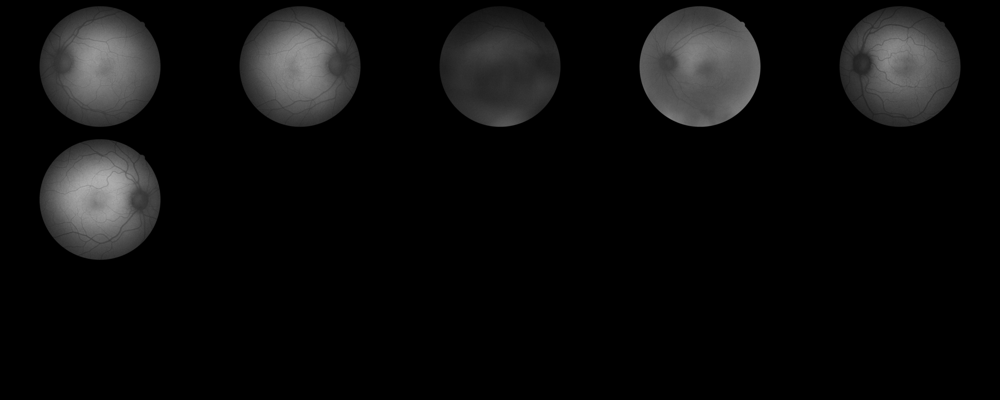

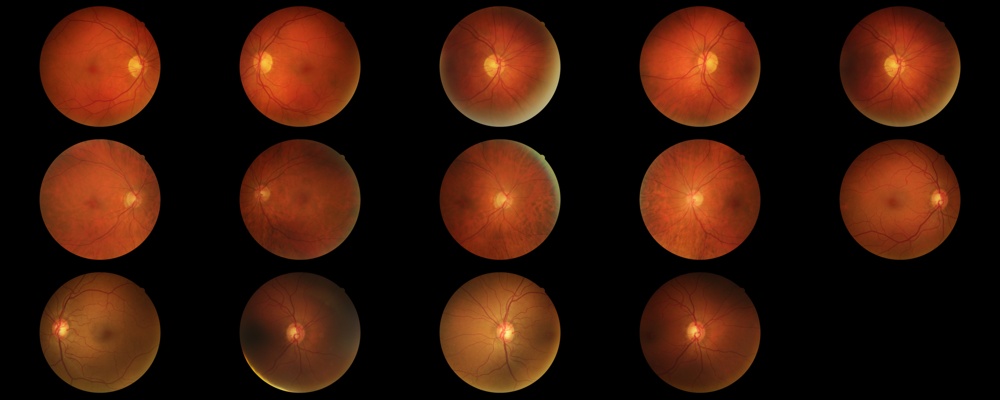

In [41]:
# image collage function
def create_collage(image_files, collage_size=(1000, 400)):
    collage = Image.new('RGB', collage_size)
    x_offset = 0
    y_offset = 0
    for img_file in image_files:
        img = Image.open(os.path.join(data_path, img_file))
        img.thumbnail((200, 200))
        collage.paste(img, (x_offset, y_offset))
        x_offset += img.width
        if x_offset >= collage.width:
            x_offset = 0
            y_offset += img.height
    return collage

cluster_1_images = [file_name for file_name in cluster_1_files]
collage_cluster_1 = create_collage(cluster_1_files)
display(collage_cluster_1)

cluster_2_images = [file_name for file_name in cluster_2_files]
collage_cluster_2 = create_collage(cluster_2_files)
display(collage_cluster_2)

In [31]:
latent_csv = pd.DataFrame({'Name':name_list, 'Latent_feature':feature_list})
latent_csv.to_csv('feature_latent.csv', index = False, encoding='utf8')